# BBC Arabic News Analysis Project
#### Created by, Ahmed Sayed

This project will show you the analysis of BBC Arabic youtube channel over last ten years.

## Google APIs

I will use HTTP requests to access the API instead of google libraries.

In [1]:
DEVELOPER_KEY = ""
YOUTUBE_API_SERVICE_NAME = "youtube"
YOUTUBE_API_VERSION = "v3"

### I will use the following function to get data from API.  

###### I got about 53 csv files from different key words to collect data.

In [2]:
def youtube_search(q, max_results=50,order="relevance", token=None, location=None, location_radius=None):

    youtube = build(YOUTUBE_API_SERVICE_NAME, YOUTUBE_API_VERSION,
      developerKey=DEVELOPER_KEY)


    search_response = youtube.search().list(
        q=q,
        type="video",
        pageToken=token,
        order = order,
        channelId = 'UCelk6aHijZq-GJBBB9YpReA',
        part="id,snippet",
        maxResults=max_results,
        location=location,
        locationRadius=location_radius,
        videoDuration="any"

    ).execute()
    
    # create a CSV output for video list    
    csvFile = open('videos53.csv','w+')
    csvWriter = csv.writer(csvFile)
    csvWriter.writerow(["title","videoId","viewCount","likeCount","dislikeCount","commentCount","videoDuration", "Date"])
    
    # Add each result to the appropriate list, and then display the lists of
    # matching videos
    for search_result in search_response.get("items", []):
        if search_result["id"]["kind"] == "youtube#video":
            #videos.append("%s (%s)" % (search_result["snippet"]["title"],search_result["id"]["videoId"]))
            title = search_result["snippet"]["title"]
            title = unidecode.unidecode(title) 
            videoId = search_result["id"]["videoId"]
            
            video_response = youtube.videos().list(
                id=videoId,
                part='statistics, contentDetails, status, snippet').execute()
            
            # Get data from youtube.videos().list
            for video_result in video_response.get("items",[]):
                viewCount = video_result["statistics"]["viewCount"]
                if "publishedAt" not in video_result["snippet"]:
                    Date = '0000-00-00'
                else:
                    Date = video_result["snippet"]["publishedAt"]
                if "duration" not in video_result["contentDetails"]:
                    videoDuration = 0
                else:
                    videoDuration = video_result["contentDetails"]["duration"]
                if 'likeCount' not in video_result["statistics"]:
                    likeCount = 0
                else:
                    likeCount = video_result["statistics"]["likeCount"]
                if 'dislikeCount' not in video_result["statistics"]:
                    dislikeCount = 0
                else:
                    dislikeCount = video_result["statistics"]["dislikeCount"]
                if 'commentCount' not in video_result["statistics"]:
                    commentCount = 0
                else:
                    commentCount = video_result["statistics"]["commentCount"]
                    
            csvWriter.writerow([title,videoId,viewCount,likeCount,dislikeCount,commentCount,videoDuration,Date])

    csvFile.close()
    
    
# key_words = ['BBCArabicNews', 'BBC News عربي', 'BBC Arabic']
# youtube_search('BBCArabicNews')

### Import some important libraries to help me in this analysis.

In [1]:
import pandas as pd
from pandas.plotting import table
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import style
from sklearn import preprocessing
from sklearn import svm
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
style.use('fivethirtyeight')

### The CSV file that we read data from is containing 8 columns representing as following:

1. ##### title:
The title of the videos that we collected form the channel.
2. ##### videoId: 
The unique id for each video from the channel.
3. ##### viewCount:
The number of people who watch the videos that is collected.
4. ##### likeCount:
The number of likes that people hit on each video on the channel.
5. ##### dislikeCount:
The number of dislikes that people hit on each video on the channel.
6. ##### commentCount:
The number of comments the made be people who watched the videos.
7. ##### videoDuration:
The duration of each video per M minutes and S for seconds.
8. ##### Date:
The date was created by each video from 2007 till 2018.

In [38]:
#All columns ["videoId","viewCount","likeCount","dislikeCount","commentCount","videoDuration","Date"] 
df = pd.read_csv('AllVideos.csv', header=0, engine='python')

df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
mask = pd.notnull(df['Date'])
df = df.loc[mask, :]

Every CSV file that I got from different keywords may be contain some duplicated videos, so I have to drop them to clean the data and reset the index column.

In [39]:
#remove duplicates
df = df.drop_duplicates(subset=['videoId'])
df = df.reset_index(drop=True)
df.head().style

,Unnamed: 0,title,videoId,viewCount,likeCount,dislikeCount,commentCount,videoDuration,Date
0,0,BBC Arabic Live - lbth lmbshr ltlfzywn by by sy `rby,HxI2TxhhS9A,7625430,0,0,0,PT0S,2017-11-15 17:19:26
1,1,lsbH@ lmSry@ fryd@ hshm: fy mSr yhtmwn bk b`d 'n tHqq njz,stZd-fLiG6w,357,25,3,12,PT2M59S,2018-07-23 16:51:18
2,2,by_by_sy_trndynG | m`lwmt l #by_by_sy tshyr l~ 'n #qTr qd tkwn df`t 'kbr fdy@ fy ltrykh,oTrjLX-VyaM,30927,332,108,218,PT6M42S,2018-07-18 16:26:08
3,3,by_by_sy_trndynG | #`dnn_'wktr ld`y@ lslmy wnsw'h lrqSt fy qbD@ lshrT@ fy #trky,qsMpwPvU4Fc,477487,4343,728,1864,PT8M2S,2018-07-12 15:56:27
4,4,"by_by_sy_trndynG: hl 'khT' #lsysy fy nTq mSTlH ""lSwrykh lblysty@""?",Zp-KCCDW7c0,899927,4127,1594,2400,PT9M24S,2018-04-16 16:03:43


After removing duplcates, the data contains duration column that represents duration of each video. So we should extract the video duration per minutes to work with it later. We have to drop videoDuration column and call the new one DurationMin.

In [40]:
dur = np.array(df['videoDuration'])
dur1 = []

for i in dur:
    if i[3] == 'M':
        dur1.append(int(i[2]))
    elif i[3] == 'H':
        if len(i)==4:
                dur1.append(60)
        else:
                dur1.append(60+int(i[4:6]))
    elif i[3] == 'S':
        dur1.append(0)
    else:
        dur1.append(int(i[2:4]))
      
dur = np.array(dur1)
df['DurationMin'] = dur

In [41]:
df = df.drop(['videoDuration'],axis=1)

As far as we go I set the date column as index and sort the dataset to work with it correctly. Then we should take a look on data set to see what is realy look like.

In [42]:
df.reset_index().set_index('Date')
pd.to_datetime(df.Date, format='%Y-%m-%d', errors='ignore')
df = df.set_index(df.Date)
df = df.sort_index(axis=0,kind='quicksort')
df = df.drop(columns=['Unnamed: 0','title','Date'],axis=1)

In [43]:
df.head(15).style

,videoId,viewCount,likeCount,dislikeCount,commentCount,DurationMin
Date,,,,,,
2007-01-27 01:20:19,tWaMcTS2kIE,20620,31,1,7,19
2008-03-11 14:41:46,8fx1mjpNvUk,28989,11,0,6,9
2008-03-12 08:45:03,vwxXLZcCTb4,46175,71,4,7,7
2008-04-26 08:37:54,03eybYIRVZQ,31527,56,1,16,1
2008-07-08 19:33:21,REzgPeTqFZA,24037,55,4,1,1
2009-01-12 11:40:15,fyo0RAkDIR8,12114,39,1,7,3
2009-05-13 01:46:51,_TytRBiZaxI,338482,1152,417,1163,9
2009-07-21 10:22:05,pL-snd4OqgM,170,0,0,0,2
2009-07-26 10:41:20,j8B-ZjbQ8s8,60136,124,6,18,1


Till now we cleaned up and handled the dataset, that lead us into describe what we did, and as we see below we have 637 videos with views average 1628626 and standard deviation 7836149. The standard deviation of all columns is so big, and by that dataset is widely distributed above and below the mean, so we should look for the videos which cause that difference.

In [44]:
df.describe().style

,viewCount,likeCount,dislikeCount,commentCount,DurationMin
count,637,637,637,637,637
mean,162863,764.873,132.505,223.177,19.6656
std,783615,3630.56,460.26,753.143,17.8517
min,3,0,0,0,0
25%,1395,9,1,1,5
50%,8461,57,8,11,13
75%,43419,343,43,98,29
max,9.47714e+06,80572,6681,12146,87


As we saw above the videos with high views affect on the entire dataset, so that the following code may be reduse the effect of those videos and drop rows which has high views.

In [45]:
df = df[df.viewCount < 200000]
df = df[df.DurationMin != 0]

### All data over last ten years.

As we see below according to what the middle east was going through from 2010 to 2017 we
obtain that the videos is exponentialy increasing till that moment and therefore
the viewers of the channel increases.

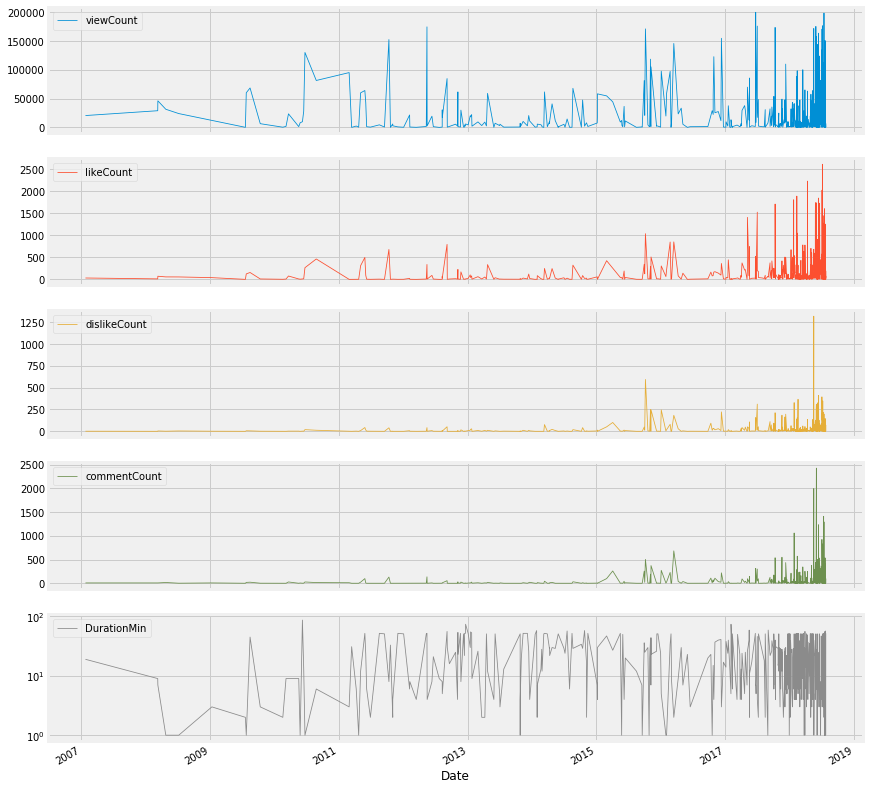

In [46]:
df.plot(subplots=True, figsize=(13, 15),linewidth=0.8)
plt.yscale('log')
plt.show()

### Improve dataset for percent of views, likes, dislikes, comments and duration columns.

In [47]:
likes = sum(df.likeCount)
dislikes = sum(df.dislikeCount)
views = sum(df.viewCount)
comments = sum(df.commentCount)

data = {
      'views':df.viewCount,
      'likes':df.likeCount,
      'dislikes':df.dislikeCount,
      'comments':df.commentCount,
      'duration':df.DurationMin
}

df = pd.DataFrame(data=data)

### Resampling data frame by the expected value of each month.

In [48]:
df = df.resample('M').mean()
df.dropna(inplace=True)
df = df[df['views'] != 0]
df.head(20).style
df.describe().style

,views,likes,dislikes,comments,duration
count,92,92,92,92,92
mean,21209.7,105.567,18.0261,34.1906,22.018
std,21240.1,124.084,28.801,59.8906,14.3033
min,51,0,0,0,1
25%,4465.25,11.5,1,1,10.8333
50%,13797.1,50.1,5.41667,8.5,20.3667
75%,29299.5,153.609,23.5197,43.881,29.0625
max,81510,463,124.5,341,52


## Some useful graphs for the data.

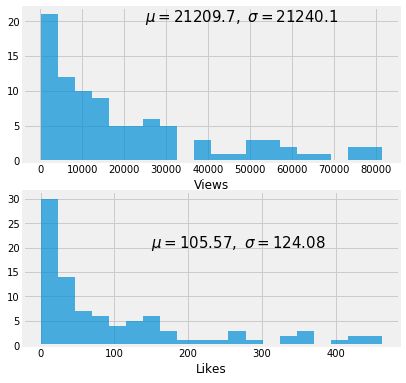

In [53]:
plt.subplot(211)
plt.hist(df['views'],20,alpha=0.7)
plt.xlabel('Views')
plt.text(25000, 20, r'$\mu=21209.7,\ \sigma=21240.1$',fontsize=15)

plt.subplot(212)
plt.hist(df['likes'],20,alpha=0.7)
plt.xlabel('Likes')
plt.text(150, 20, r'$\mu=105.57,\ \sigma=124.08$',fontsize=15)

plt.subplots_adjust(top=1.3)

plt.show()

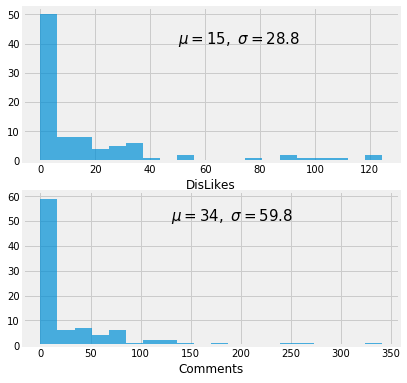

In [71]:
plt.subplot(211)
plt.hist(df['dislikes'],20,alpha=0.7)
plt.xlabel('DisLikes')
plt.text(50, 40, r'$\mu=15,\ \sigma=28.8$',fontsize=15)

plt.subplot(212)
plt.hist(df['comments'],20,alpha=0.7)
plt.xlabel('Comments')
plt.text(130, 50, r'$\mu=34,\ \sigma=59.8$',fontsize=15)

plt.subplots_adjust(top=1.3)
                    
plt.show()

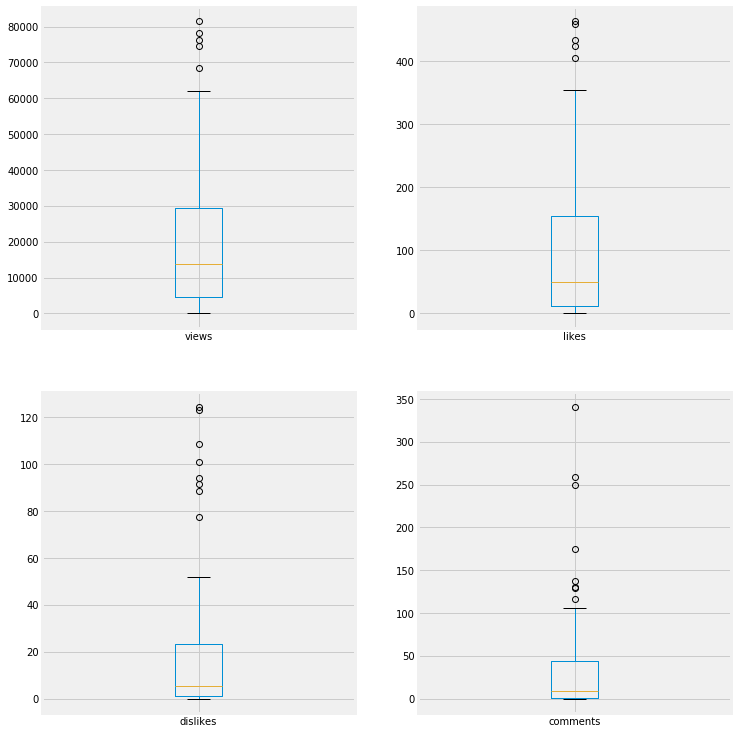

In [84]:
plt.subplot(221)
df.views.plot.box(figsize=(11,13))

plt.subplot(222)
df.likes.plot.box()

plt.subplot(223)
df.dislikes.plot.box()

plt.subplot(224)
df.comments.plot.box()

Text(0.5,0,'duration (m)')

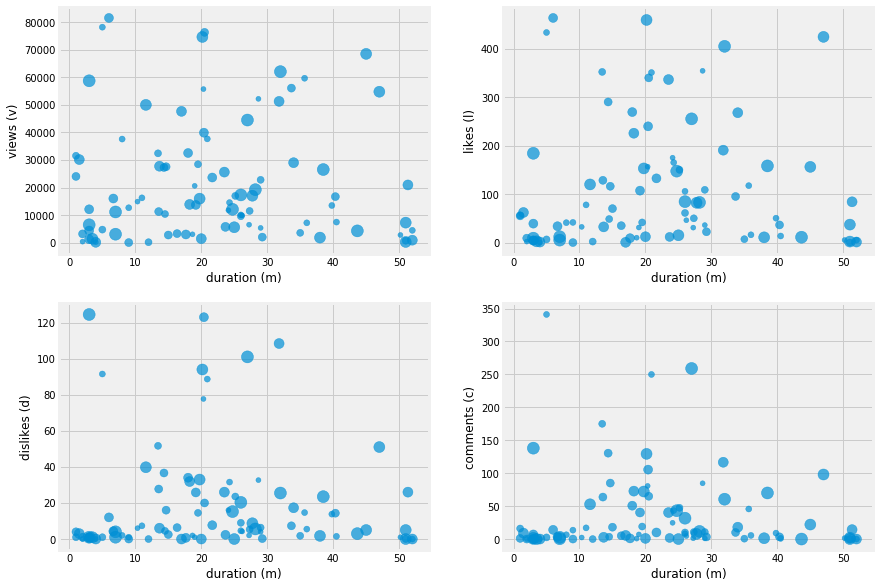

In [138]:
plt.figure(figsize=(13,10))
area = [i**2 for i in range(5,13)]

plt.subplot(221)
plt.scatter(df.duration,df.views,s=area,alpha=0.7)
plt.ylabel('views (v)')
plt.xlabel('duration (m)')

plt.subplot(222)
plt.scatter(df.duration,df.likes,s=area,alpha=0.7)
plt.ylabel('likes (l)')
plt.xlabel('duration (m)')

plt.subplot(223)
plt.scatter(df.duration,df.dislikes,s=area,alpha=0.7)
plt.ylabel('dislikes (d)')
plt.xlabel('duration (m)')

plt.subplot(224)
plt.scatter(df.duration,df.comments,s=area,alpha=0.7)
plt.ylabel('comments (c)')
plt.xlabel('duration (m)')

## Create predictive models with some algorithms and we'll use it to predict whether the person will click on the video or not.

#### Make the labels of the predictions from one of video features and map it to label column.

In [127]:
def create_labels(view, duration):
    if view > 30000 and duration < 30:
            return 1
    else:
            return 0

df['label'] = list(map(create_labels,df['views'],df['duration']))
df.head(20).style

,views,likes,dislikes,comments,duration,label
Date,,,,,,
2007-01-31 00:00:00,20620,31,1,7,19,0
2008-03-31 00:00:00,37582,41,2,6.5,8,1
2008-04-30 00:00:00,31527,56,1,16,1,1
2008-07-31 00:00:00,24037,55,4,1,1,0
2009-01-31 00:00:00,12114,39,1,7,3,0
2009-07-31 00:00:00,30153,62,3,9,1.5,1
2009-08-31 00:00:00,68473,156,5,22,45,0
2009-10-31 00:00:00,6492,9,1,1,3,0
2010-02-28 00:00:00,391,2,0,0,2,0


### I should prepare the test and training dataset for the models, so let's test the algorithm over 20% of all data and print the accuracy of the algorithm.

#### I'm gonna use the following predictive models:

1. Support Victor Machine SVM.

2. Naive Bayes NB.

3. K Nearest Neighbor KNN.

4. Decision Tree DT.

5. Random Forest RF.


In [139]:
X = np.array(df.drop(['views','label','duration'],1))
y = np.array(df['label'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

clf = svm.SVC()
gnb = GaussianNB()
knn = KNeighborsClassifier(n_neighbors=1)
dtc = DecisionTreeClassifier()
rfc = RandomForestClassifier()

clf.fit(X_train,y_train)
gnb.fit(X_train,y_train)
knn.fit(X_train,y_train)
dtc.fit(X_train,y_train)
rfc.fit(X_train,y_train)

df.head(25).style

,views,likes,dislikes,comments,duration,label
Date,,,,,,
2007-01-31 00:00:00,20620,31,1,7,19,0
2008-03-31 00:00:00,37582,41,2,6.5,8,1
2008-04-30 00:00:00,31527,56,1,16,1,1
2008-07-31 00:00:00,24037,55,4,1,1,0
2009-01-31 00:00:00,12114,39,1,7,3,0
2009-07-31 00:00:00,30153,62,3,9,1.5,1
2009-08-31 00:00:00,68473,156,5,22,45,0
2009-10-31 00:00:00,6492,9,1,1,3,0
2010-02-28 00:00:00,391,2,0,0,2,0


#### Since we have 2 features and that is pretty small, so the Naive Bayes is the best predictive model for the dataset.

In [805]:
print('\nThe accuracy of the SVM algorithm: ' + str(round(float(clf.score(X_test,y_test))*100,2))+'%')
print('\nThe accuracy of the NB algorithm: ' + str(round(float(gnb.score(X_test,y_test))*100,2))+'%')
print('\nThe accuracy of the KNN algorithm: ' + str(round(float(knn.score(X_test,y_test))*100,2))+'%')
print('\nThe accuracy of the DT algorithm: ' + str(round(float(dtc.score(X_test,y_test))*100,2))+'%')
print('\nThe accuracy of the RF algorithm: ' + str(round(float(rfc.score(X_test,y_test))*100,2))+'%')


The accuracy of the SVM algorithm: 84.21%

The accuracy of the NB algorithm: 94.74%

The accuracy of the KNN algorithm: 68.42%

The accuracy of the DT algorithm: 73.68%

The accuracy of the RF algorithm: 78.95%


### In conclusion:
- The increasing of channel performance depends on the fact of the news and reducing the duration of each video form 2 to 30 minutes is prefered.
- The ML model predicts whether the person will click on the video or not if there are some conditions is achieved.